# Compute point source fringe depth as a function of which part of the PSF is sampled

### Define path to data and set flags

### <font color='green'> --Modify following path to the folder where the miri_mrs_point_source_fringes folder resides </font>

In [1]:
user_dir = '/Users/ioannisa/Desktop/python/miri_mrs_point_source_fringes/'

### <font color='green'> --Choose if you wish to save plots (default is True) </font>

In [2]:
save_plots = True

### <font color='red'> --Do NOT change following paths </font>

In [3]:
datapath   = user_dir+'data/'
figurepath = user_dir+'figures/'
outputpath = user_dir+'output_files/'

In [4]:
import os
import itertools
import numpy as np
from astropy.io import fits
from scipy.stats import norm
from scipy.optimize import curve_fit
import scipy.interpolate as scp_interpolate
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append(user_dir)
from core.funcs import detpixel_trace_compactsource,find_peaks,FPfunc_noPhaseShift

In [5]:
%matplotlib notebook

### Preamble

### --Fitting functions

In [6]:
def polyfit2d(x, y, z, order=3):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**j * y**i
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z = z + a * x**j * y**i
    return z

### --MRS auxilliary data

In [7]:
band = '1A'
nslices = 21

# fringe peaks are found according to two parameters
if band == '1A':
    # 1) threshold
    thres = 0
    # 2) minimum distance between subsequent peaks
    min_dist = 6
    # Fabry-Perot transmittance function initial estimates
    R0 = 0.06    # [-]
    D0 = 0.17096 # micron

# point source fringe systematic fitting criteria
min_signal_to_fit = 1. # DN/s
polyfit_order = 4 # accounts for 4th order MRS optical distortions in the spectral and spatial directions

### --Load distortion maps

In [8]:
d2cMaps = {'sliceMap':np.load(datapath+'sliceMap.npy'),
           'lambdaMap':np.load(datapath+'lambdaMap.npy'),
           'alphaMap':np.load(datapath+'alphaMap.npy'),
           'betaMap':np.load(datapath+'betaMap.npy'),
           'nslices':nslices}

### --Load data

In [9]:
sci_img = fits.open(datapath+'CV2_P0.fits')[1].data

### --Load centroid from notebook 0

<IPython.core.display.Javascript object>


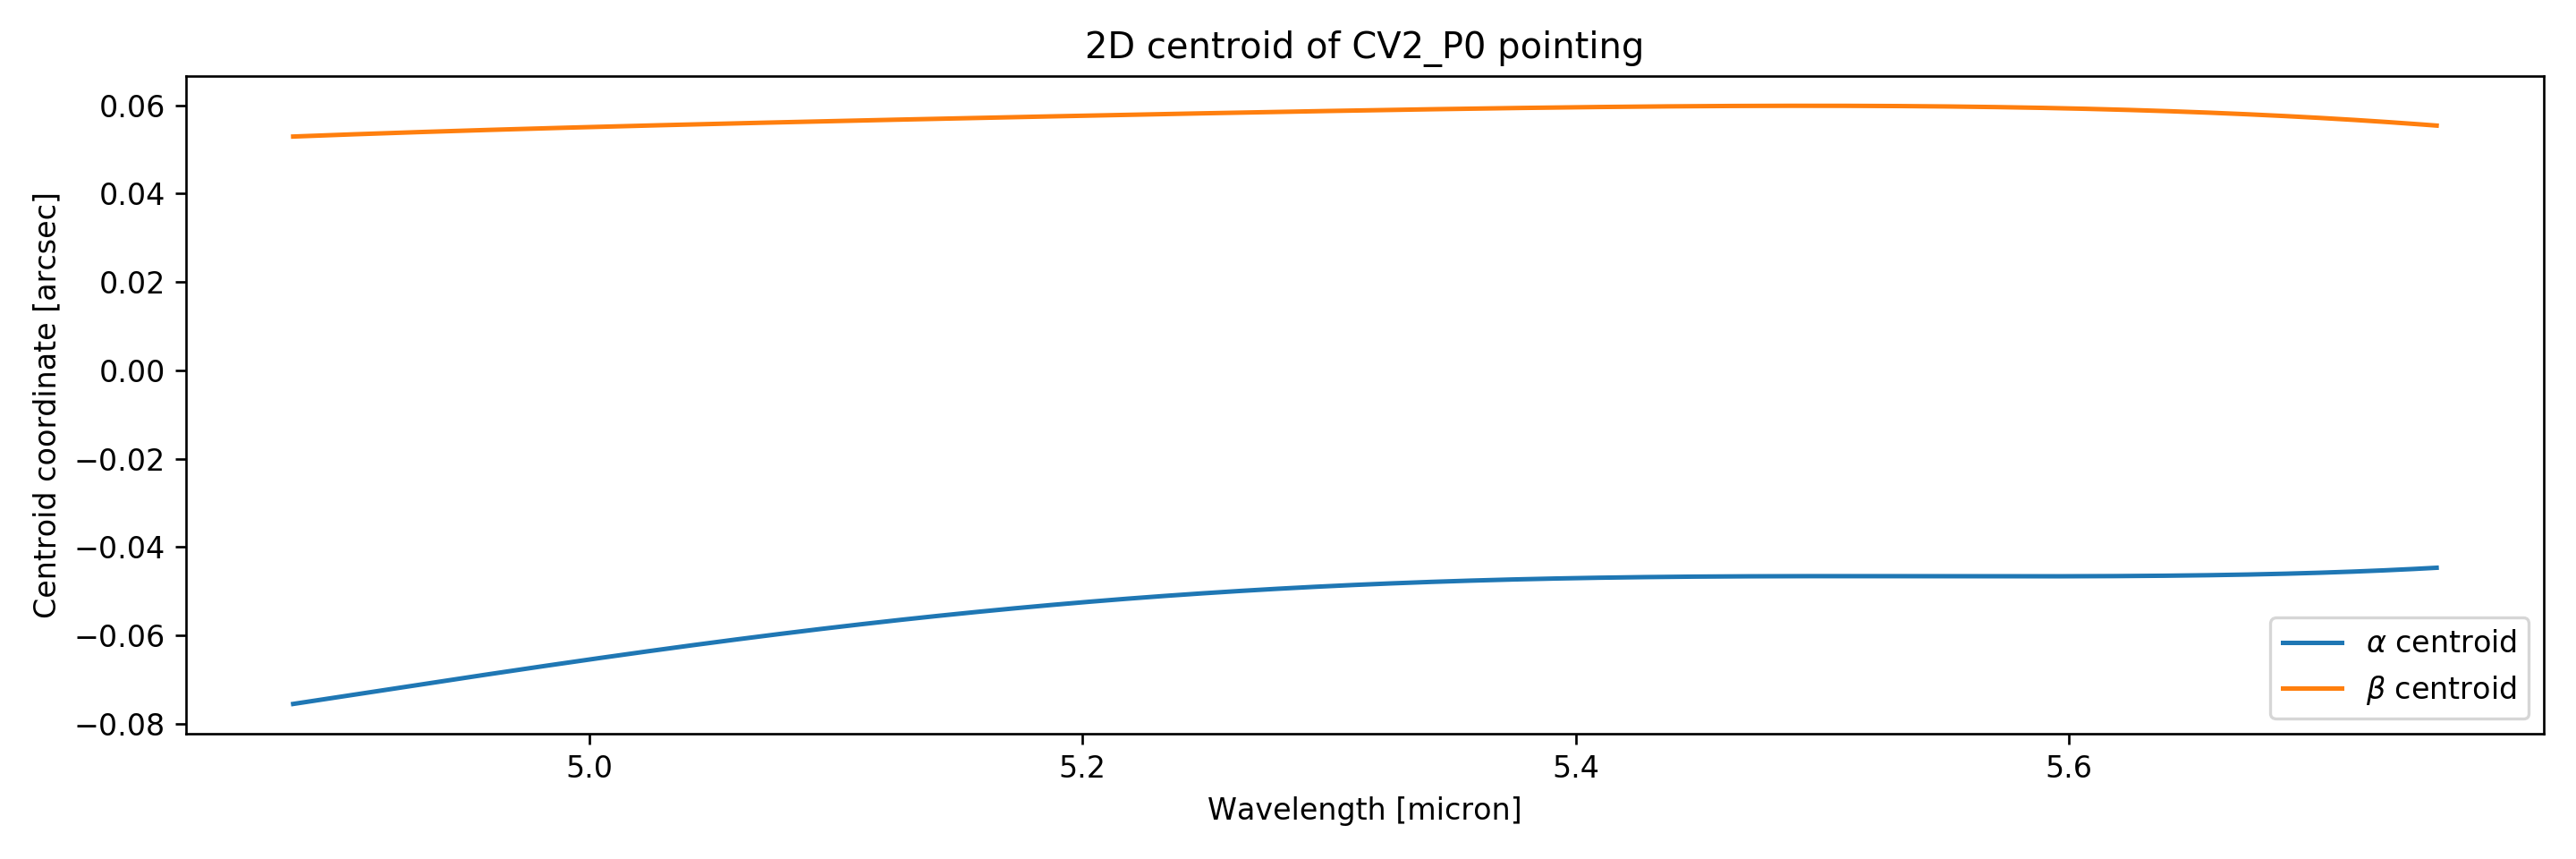

In [10]:
lambcens   = np.load(outputpath+'lambcens.npy') # micron
wavenumber = (10000./lambcens) # cm^-1

popt_alpha = np.load(outputpath+'CV2_P0_alpha_cen_polyfit.npy')
poly_alpha = np.poly1d(popt_alpha)

popt_beta  = np.load(outputpath+'CV2_P0_beta_cen_polyfit.npy')
poly_beta = np.poly1d(popt_beta)

plt.figure(figsize=(12,4))
plt.plot(lambcens,poly_alpha(lambcens),label=r'$\alpha$ centroid')
plt.plot(lambcens,poly_beta(lambcens),label=r'$\beta$ centroid')
plt.title('2D centroid of CV2_P0 pointing')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Centroid coordinate [arcsec]')
plt.legend()
plt.tight_layout()

### Fringe analysis

### --Example of signal in slice containing the PSF peak

<IPython.core.display.Javascript object>


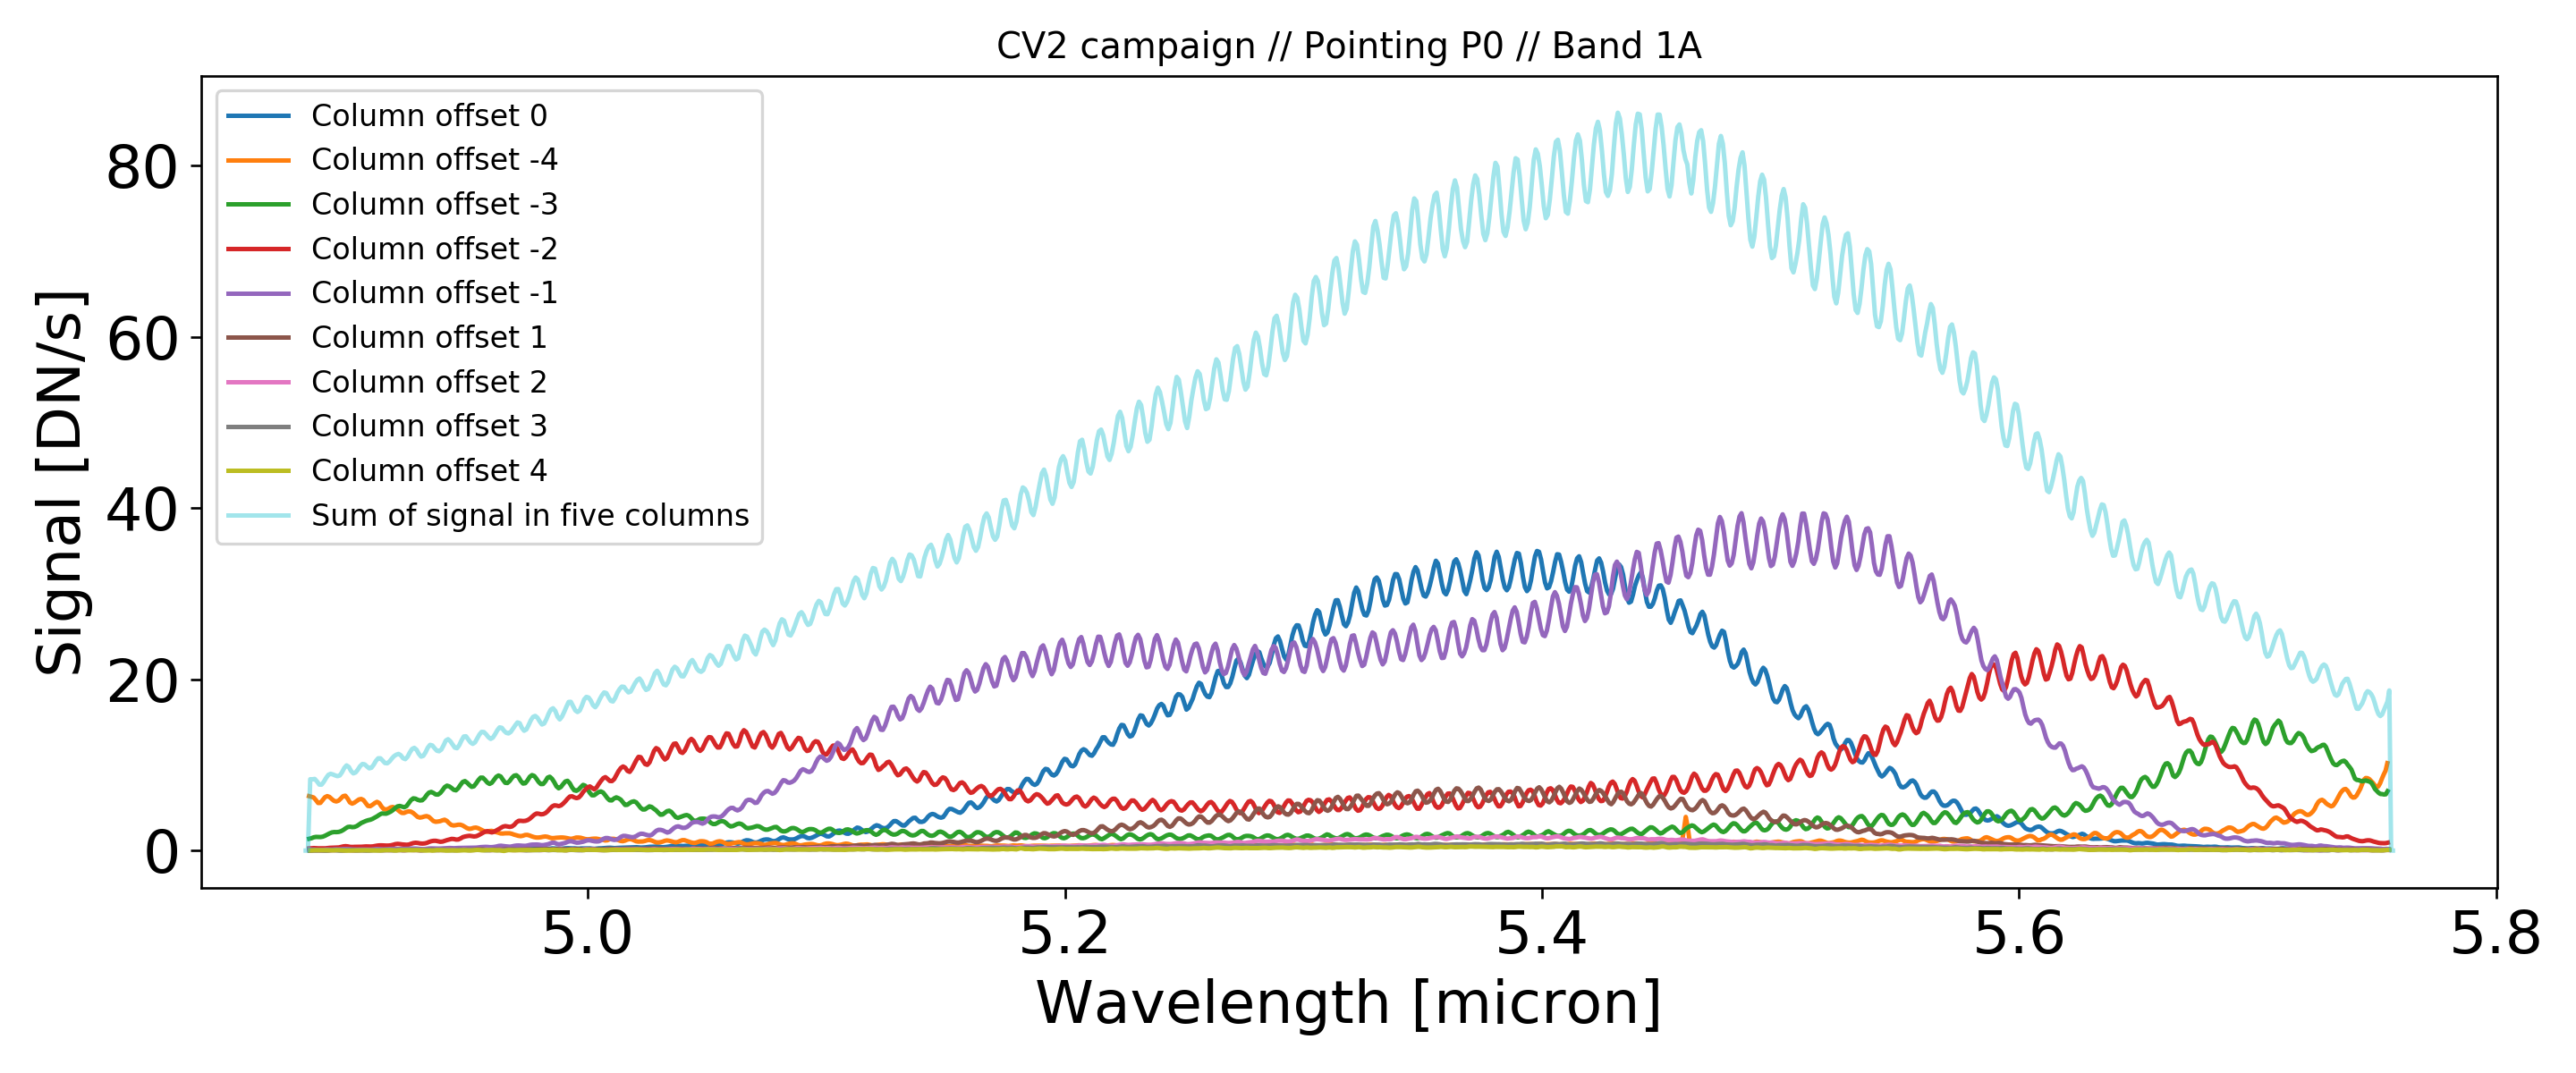

In [11]:
# Pixel trace in MRS slice
slice_offset = 0

ypos,xpos = detpixel_trace_compactsource(sci_img,band,d2cMaps,offset_slice=slice_offset)
xpos = (np.ones(len(ypos))*xpos[512]).astype(int)

# make first plot of source signal
test_spec = np.zeros(1024)
plt.figure(figsize=(12,5))
for xpos_offset in [0,-4,-3,-2,-1,1,2,3,4]:
    wavl = d2cMaps['lambdaMap'][ypos,xpos+xpos_offset]
    extracted_spectrum = sci_img[ypos,xpos+xpos_offset] # /fringe_img[ypos,xpos+xpos_offset]
    
    omit_nan = ~np.isnan(extracted_spectrum).copy()
    wavl_noNaN = wavl[omit_nan]
    extracted_spectrum_noNaN = extracted_spectrum[omit_nan]

    test_spec[omit_nan] += extracted_spectrum_noNaN
    plt.plot(wavl_noNaN,extracted_spectrum_noNaN,label='Column offset {}'.format(xpos_offset))

plt.plot(wavl,test_spec,alpha=0.4,label='Sum of signal in five columns')
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('Signal [DN/s]',fontsize=20)
plt.title('CV2 campaign // Pointing P0 // Band 1A')
plt.tick_params(axis='both',labelsize=20)
plt.legend(fontsize=10)
plt.tight_layout()

### --Analysis
* Compute the fringe depth as a function of distance from the PSF peak 
* Perform a 2D polynomial fit as a function of distance from PSF peak and wavelength (detector reflectance is wavelength dependent)

In [12]:
centered_alpha_wvnrs = {}
ps_wvnr_lists = {}
ps_fringe_depths = {}
fringe_depth_polyfit_weights = np.zeros((3,(polyfit_order + 1)**2))
for slice_offset in [-1,0,1]:
    print('Slice offset {}'.format(slice_offset))
    print('---------------')
    x,y,z = [],[],[]
    
    ypos,xpos = detpixel_trace_compactsource(sci_img,band,d2cMaps,offset_slice=slice_offset)
    xpos = (np.ones(len(ypos))*xpos[512]).astype(int)

    for xpos_offset in [-4,-3,-2,-1,0,1,2]:
        print('XPOS_OFFSET={}'.format(xpos_offset))
        wavl = d2cMaps['lambdaMap'][ypos,xpos+xpos_offset]
        extracted_spectrum =  sci_img[ypos,xpos+xpos_offset]

        sel = np.isfinite(extracted_spectrum == True)
        wavl = wavl[sel]
        extracted_spectrum  = extracted_spectrum[sel]

        positive_peaks_idxs = find_peaks(extracted_spectrum,thres=thres,min_dist=min_dist)

        # Scale to 1d spectrum continuum level (defined by fringe peaks)
        arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(positive_peaks_idxs,extracted_spectrum[positive_peaks_idxs],k=2,ext=3)
        arr_profile = arr_interpolator(range(len(extracted_spectrum)))

        fringe_transmission = extracted_spectrum/arr_profile
        fringe_transmission[(fringe_transmission >= 1.)] = 1

        # Point source fringe analysis
        ps_wvnr = np.flipud(10000./wavl)
        ps_spec = np.flipud(fringe_transmission)-0.005
        ps_peaks_wvnr = np.flipud(len(ps_wvnr)-1-np.array(positive_peaks_idxs))

        #--point source placeholders
        ps_wvnr_list = ps_wvnr[ps_peaks_wvnr]
        ps_R_list = np.full(len(ps_peaks_wvnr),np.nan)
        ps_D_list = np.full(len(ps_peaks_wvnr),np.nan)
        ps_fringe_depth = np.full(len(ps_peaks_wvnr),np.nan)

        valid_range = np.arange(2,len(ps_peaks_wvnr)-2)
        for i in valid_range:
            if i == valid_range[0]:
                R,D = R0,D0
            else:
                R,D = ps_R_list[i-1],ps_D_list[i-1]
            if np.isfinite(R) == False:
                R,D = R0,D0
            if (np.flipud(extracted_spectrum)[ps_peaks_wvnr[i]] <min_signal_to_fit):
                ps_R_list[i] = np.nan
                ps_D_list[i] = np.nan
                continue
            else:
                sel = (ps_wvnr>(ps_wvnr[ps_peaks_wvnr[i-1]]+ps_wvnr[ps_peaks_wvnr[i]])/2. ) & (ps_wvnr<(ps_wvnr[ps_peaks_wvnr[i]]+ps_wvnr[ps_peaks_wvnr[i+1]])/2. )

                try:
                    popt,pcov = curve_fit(FPfunc_noPhaseShift,ps_wvnr[sel],ps_spec[sel],p0=[R,D],bounds=((0,0),(1,np.inf)) )
                    ps_R_list[i] = popt[0]
                    ps_D_list[i] = popt[1]
                except:
                    ps_R_list[i] = ps_R_list[i-1]
                    ps_D_list[i] = ps_D_list[i-1]

                # compute linecenter empirically
                plotx = np.linspace(ps_wvnr[sel][0],ps_wvnr[sel][-1],10000)
                ploty = FPfunc_noPhaseShift(plotx,ps_R_list[i],ps_D_list[i])
                ps_wvnr_list[i] = plotx[np.argmax(ploty)]
                ps_fringe_depth[i] = ploty[np.argmin(ploty)]

        sel = np.isfinite(ps_fringe_depth)
        ps_wvnr_list = ps_wvnr_list[sel]
        ps_fringe_depth = ps_fringe_depth[sel]

        # Derive systematic trend
        interp_alpha = scp_interpolate.interp1d(np.flipud(10000./d2cMaps['lambdaMap'][ypos,xpos+xpos_offset]),np.flipud(d2cMaps['alphaMap'][ypos,xpos+xpos_offset]) )
        alpha_wvnr = interp_alpha(ps_wvnr_list)
        centered_alpha_wvnr = alpha_wvnr-poly_alpha(10000./ps_wvnr_list)

        x.extend(centered_alpha_wvnr)
        y.extend(ps_wvnr_list)
        z.extend(ps_fringe_depth)

    centered_alpha_wvnrs['slice_offset_{}'.format(slice_offset)] = np.array(x)
    ps_wvnr_lists['slice_offset_{}'.format(slice_offset)] = np.array(y)
    ps_fringe_depths['slice_offset_{}'.format(slice_offset)] = np.array(z)
    
    print('')
    
    # Fit 2d polynomial to data
    sel = (ps_fringe_depths['slice_offset_{}'.format(slice_offset)]>0.6)
    fringe_depth_polyfit_weights[slice_offset+1,:] = polyfit2d(centered_alpha_wvnrs['slice_offset_{}'.format(slice_offset)][sel],ps_wvnr_lists['slice_offset_{}'.format(slice_offset)][sel],ps_fringe_depths['slice_offset_{}'.format(slice_offset)][sel],polyfit_order)

Slice offset -1
---------------
XPOS_OFFSET=-4
XPOS_OFFSET=-3
XPOS_OFFSET=-2


/Users/ioannisa/Applications/anaconda3/envs/miricle.devel/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater_equal


XPOS_OFFSET=-1
XPOS_OFFSET=0
XPOS_OFFSET=1
XPOS_OFFSET=2

Slice offset 0
---------------
XPOS_OFFSET=-4


/Users/ioannisa/Applications/anaconda3/envs/miricle.devel/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


XPOS_OFFSET=-3
XPOS_OFFSET=-2
XPOS_OFFSET=-1
XPOS_OFFSET=0
XPOS_OFFSET=1
XPOS_OFFSET=2

Slice offset 1
---------------
XPOS_OFFSET=-4
XPOS_OFFSET=-3
XPOS_OFFSET=-2
XPOS_OFFSET=-1
XPOS_OFFSET=0
XPOS_OFFSET=1
XPOS_OFFSET=2



### --Plot raw results in one detector slice

<IPython.core.display.Javascript object>


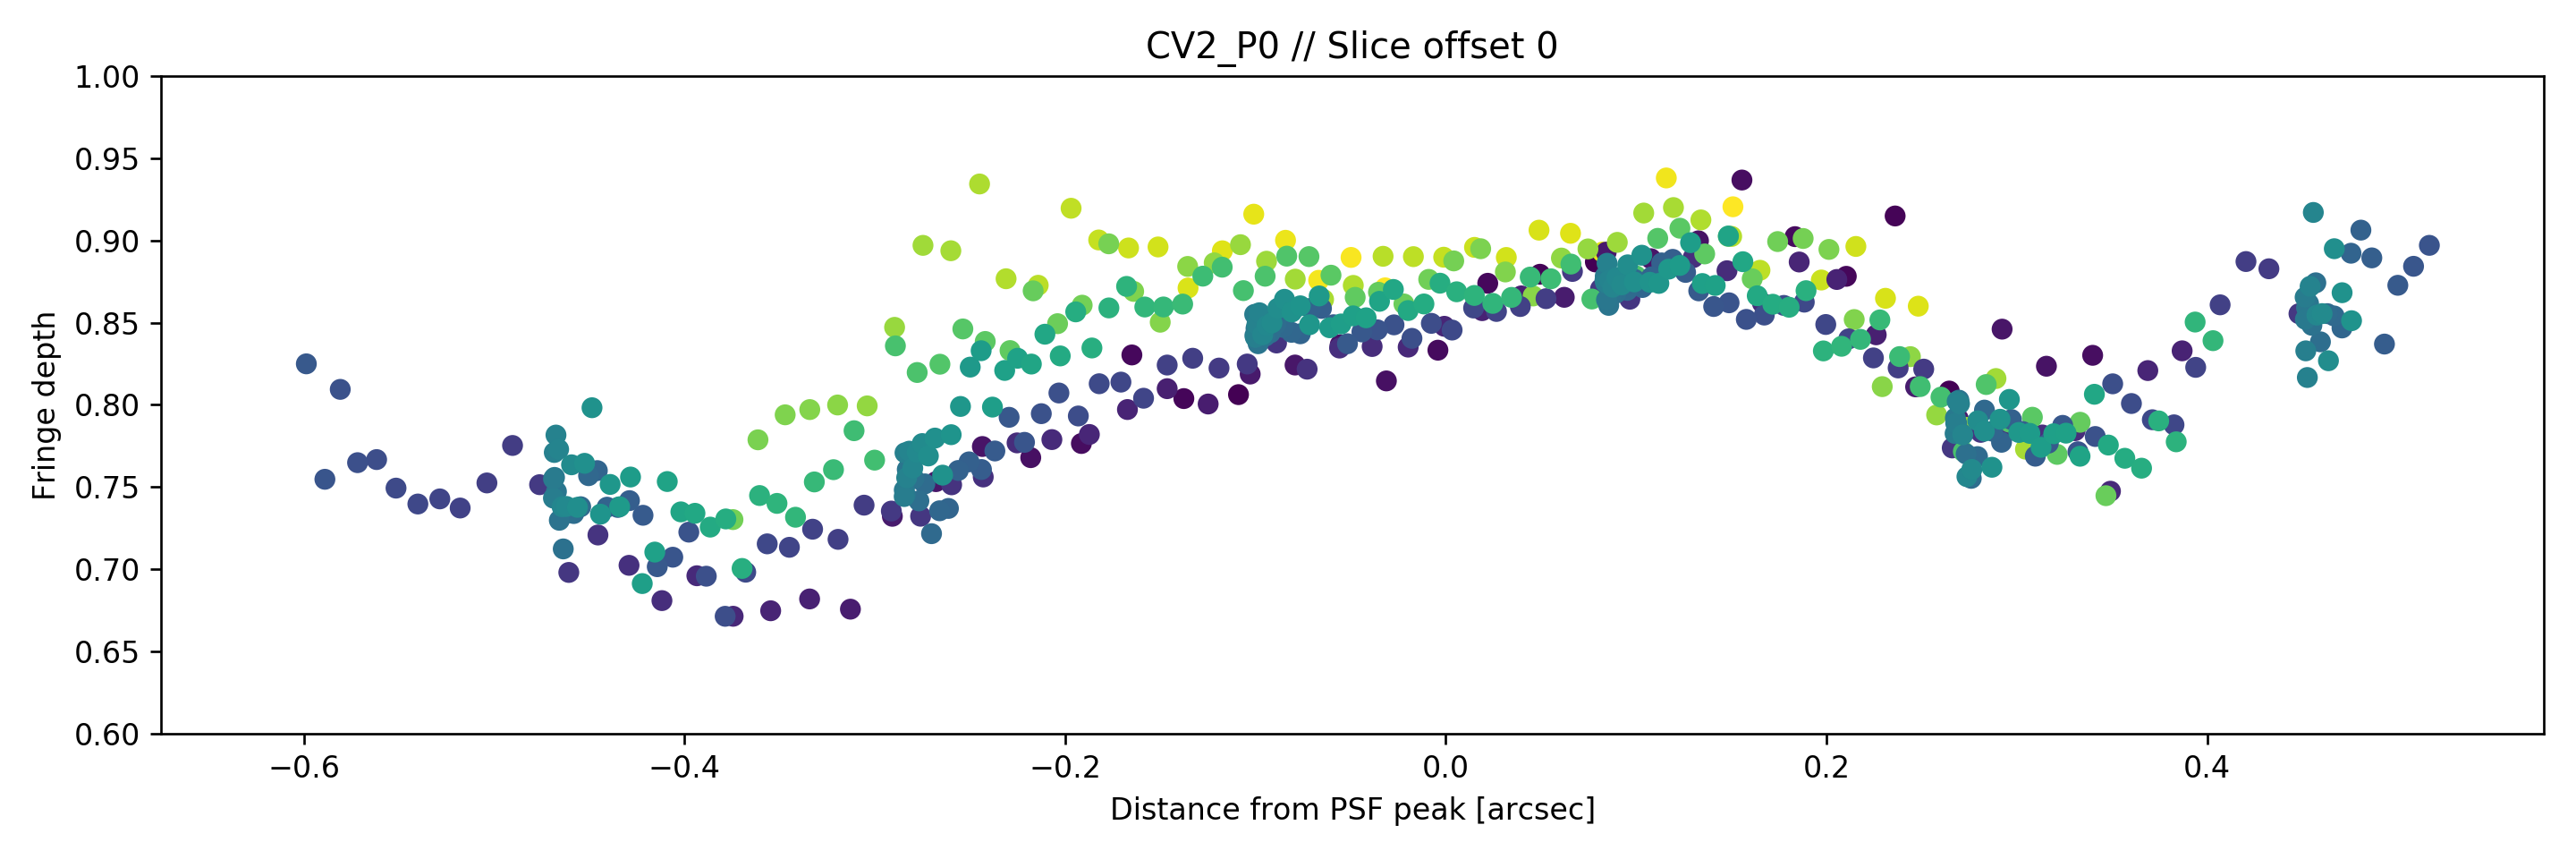

<IPython.core.display.Javascript object>


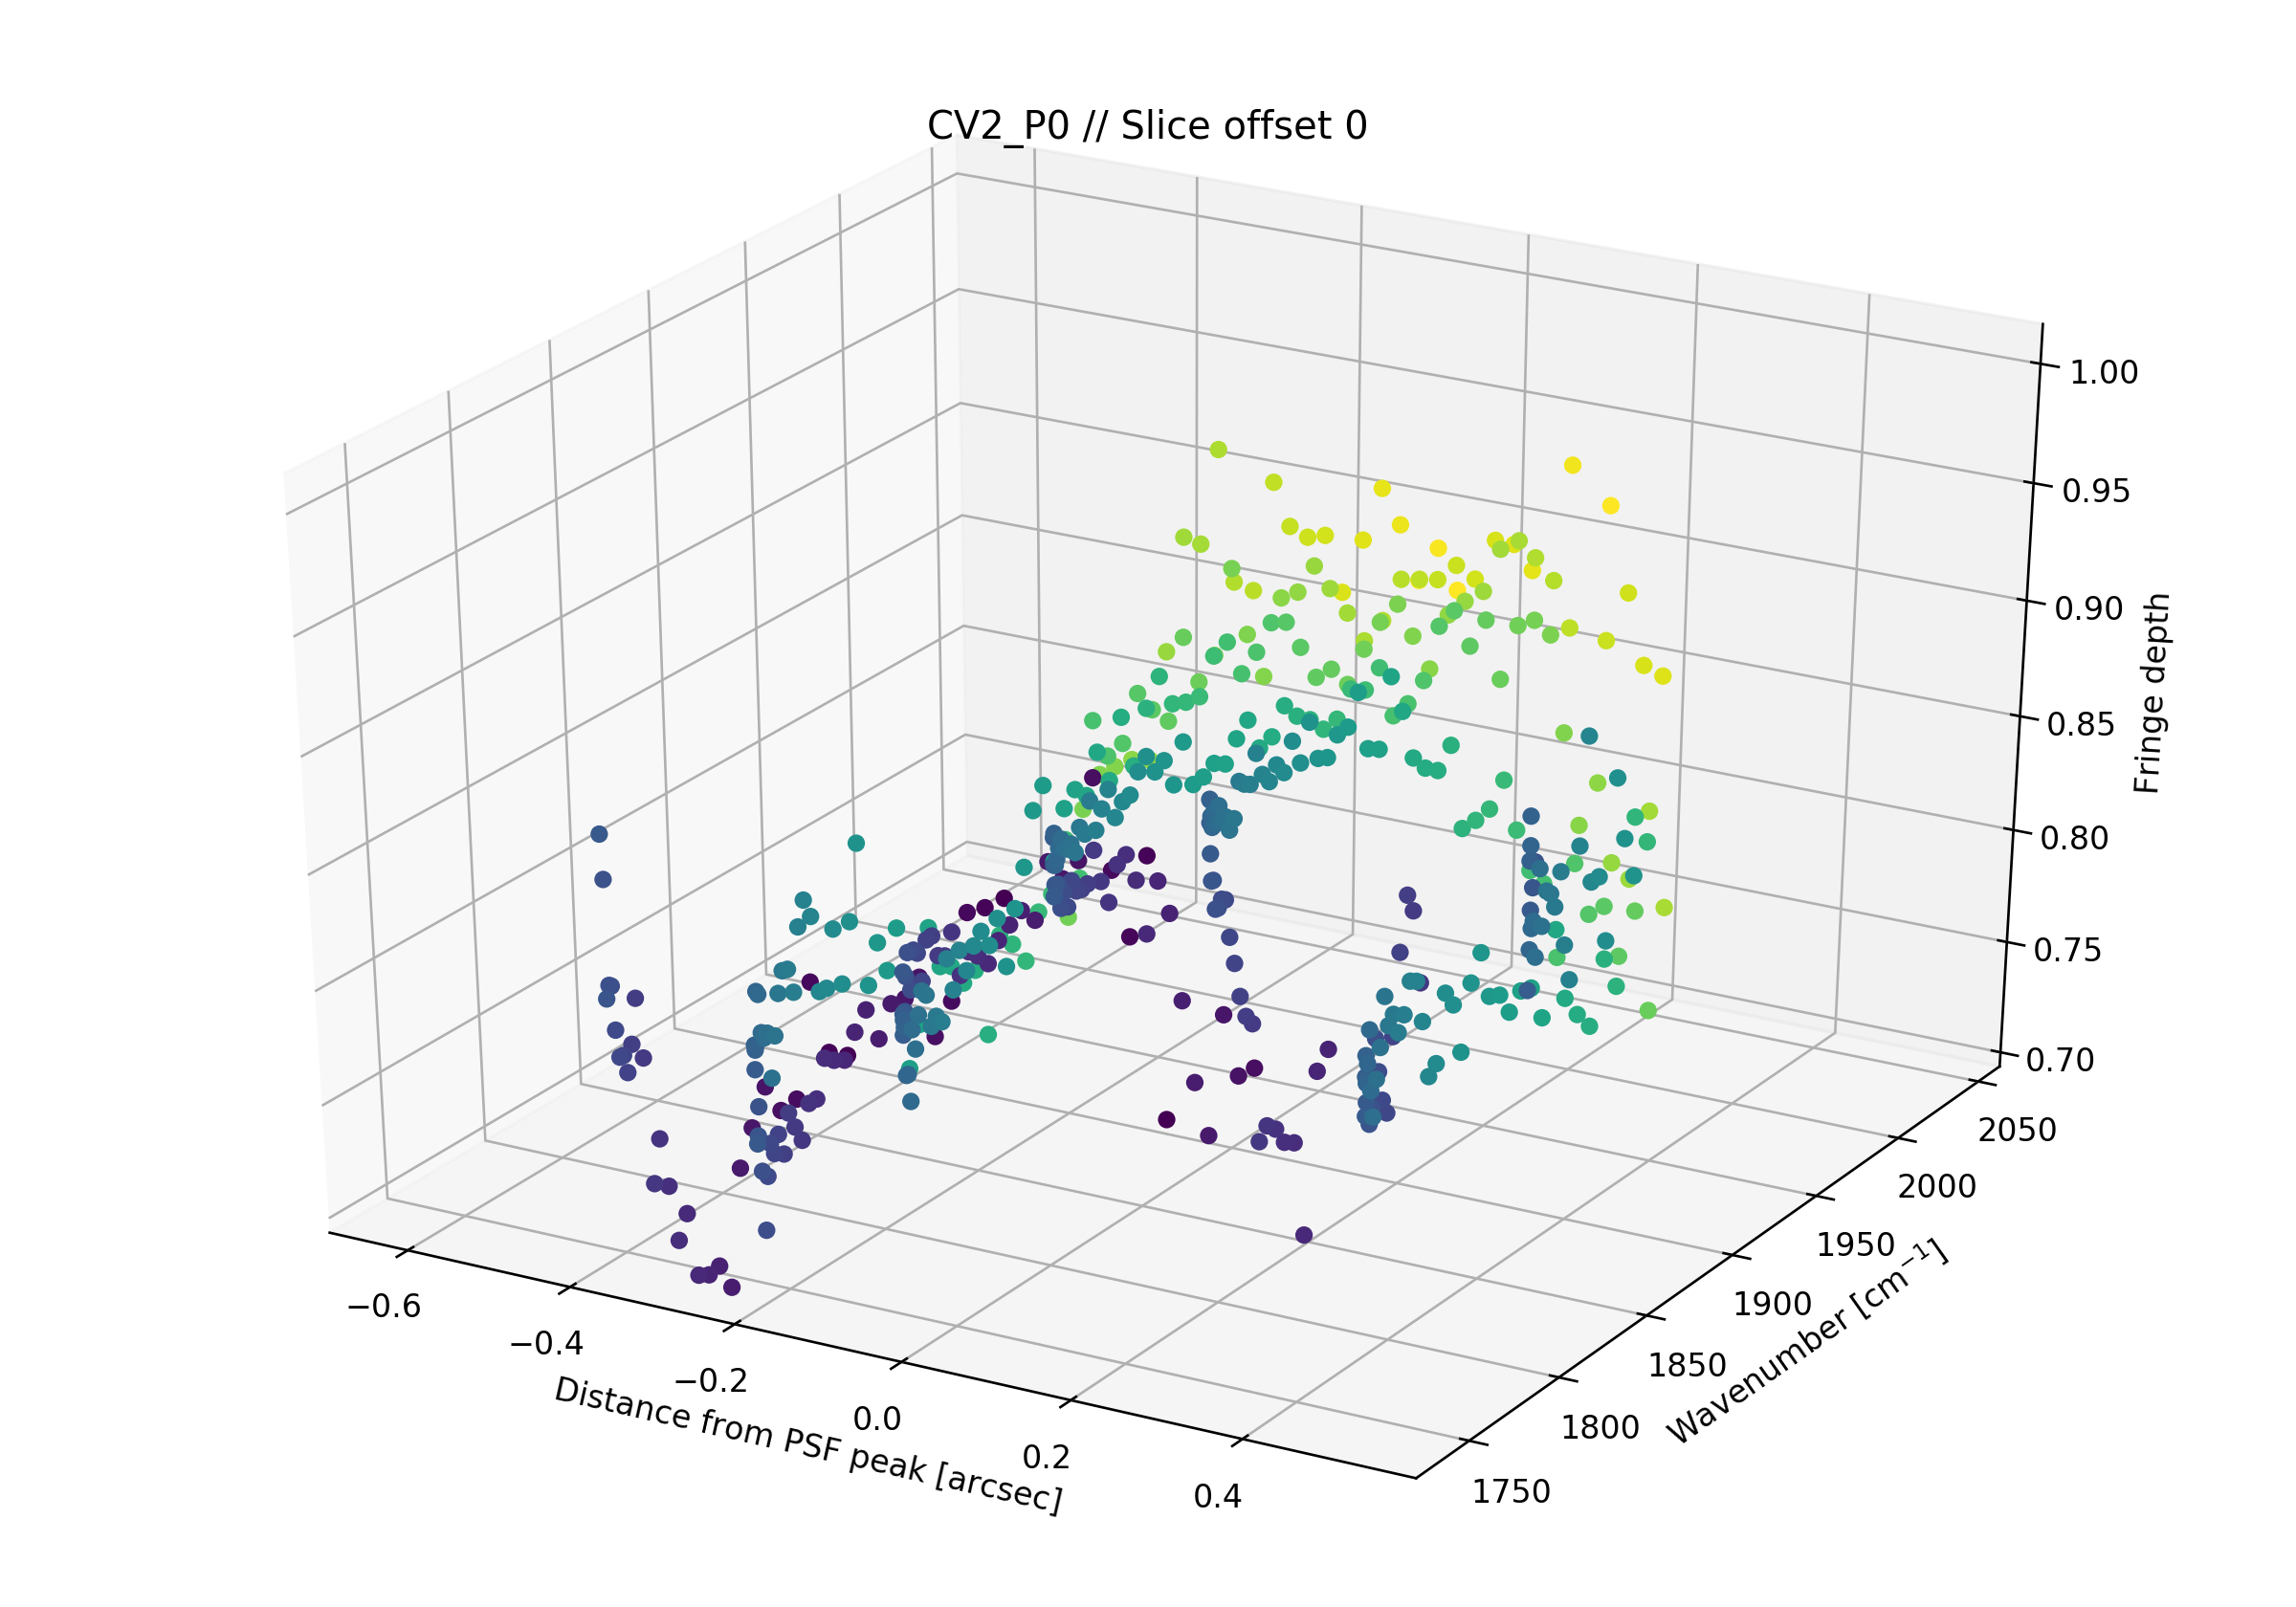

In [13]:
slice_offset = 0
key = 'slice_offset_'+str(slice_offset)

plt.figure(figsize=(12,4))
plt.scatter(centered_alpha_wvnrs[key],ps_fringe_depths[key],c=ps_wvnr_lists[key])
plt.ylim(0.6,1)
plt.xlabel('Distance from PSF peak [arcsec]')
plt.ylabel('Fringe depth')
plt.title('CV2_P0 // Slice offset '+str(slice_offset))
plt.tight_layout()

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
ax.scatter(centered_alpha_wvnrs[key],ps_wvnr_lists[key],ps_fringe_depths[key],c=ps_wvnr_lists[key],alpha=1)
ax.set_zlim(0.7,1.01)
ax.set_xlabel(r'Distance from PSF peak [arcsec]')
ax.set_ylabel(r'Wavenumber [cm$^{-1}$]')
ax.set_zlabel(r'Fringe depth')
ax.set_title('CV2_P0 // Slice offset '+str(slice_offset))
ax.tick_params(axis='both',labelsize=10)
plt.tight_layout()

### --Plot 2D fit results

<IPython.core.display.Javascript object>


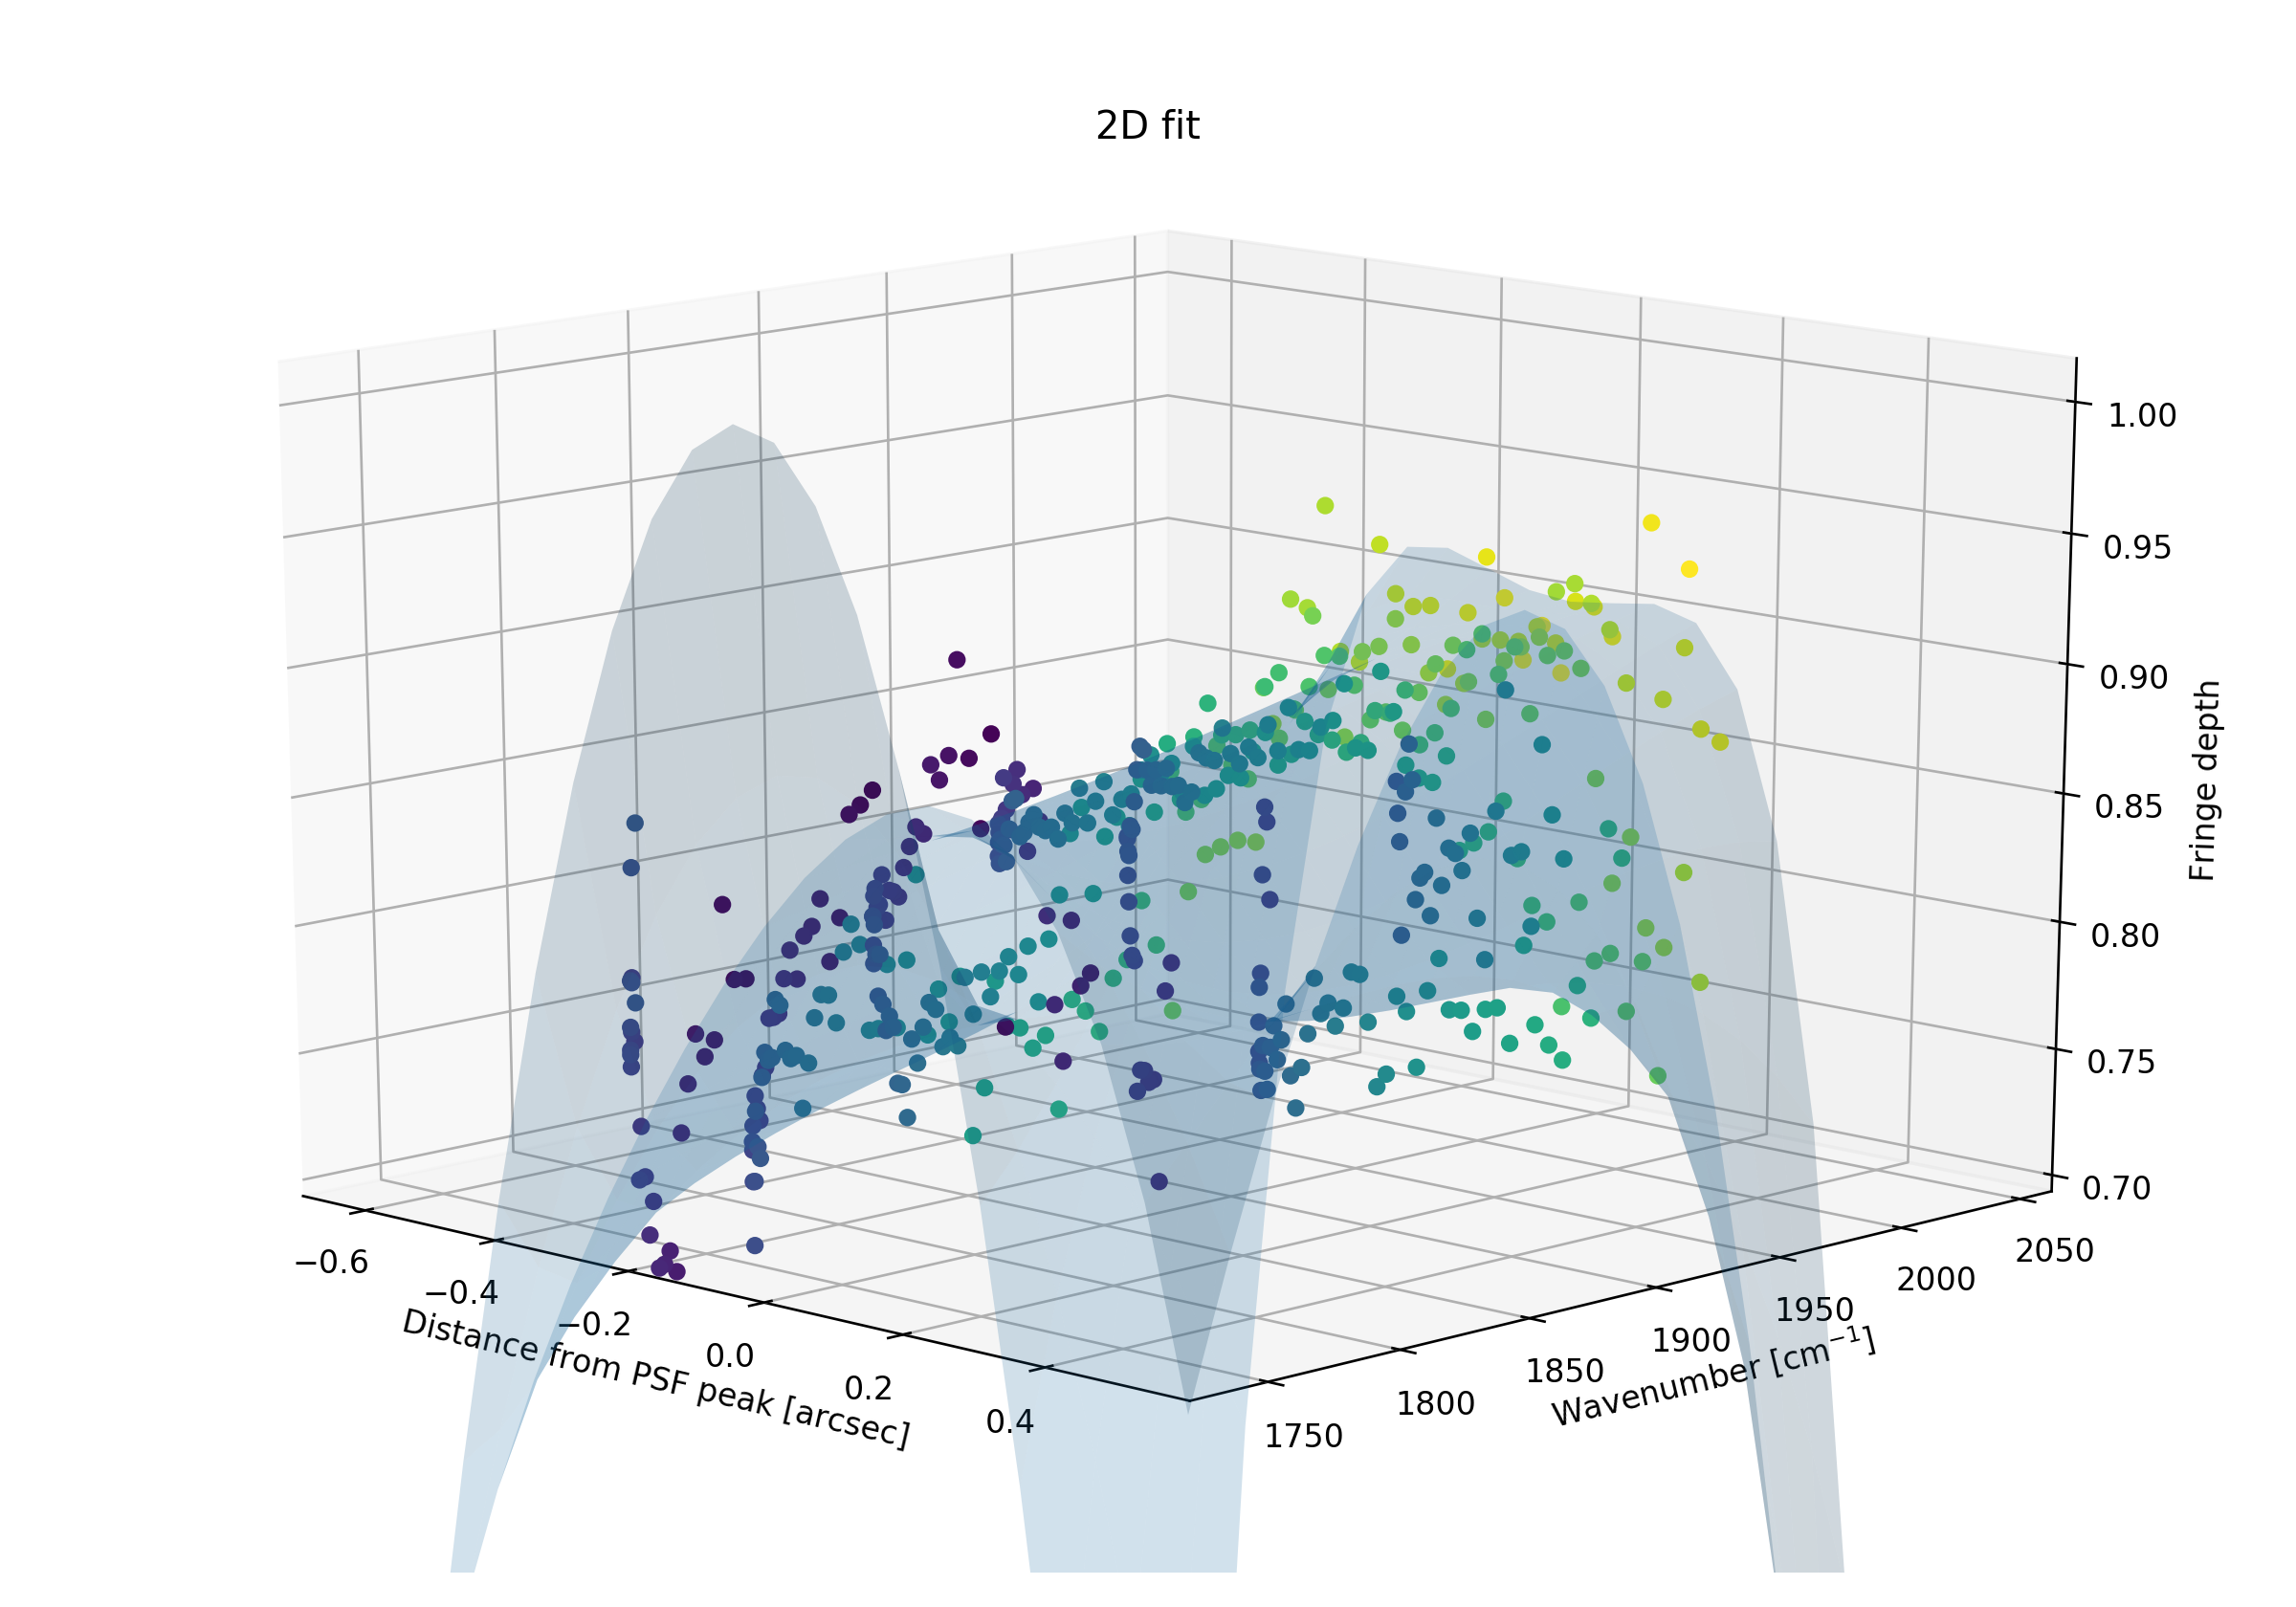

<IPython.core.display.Javascript object>


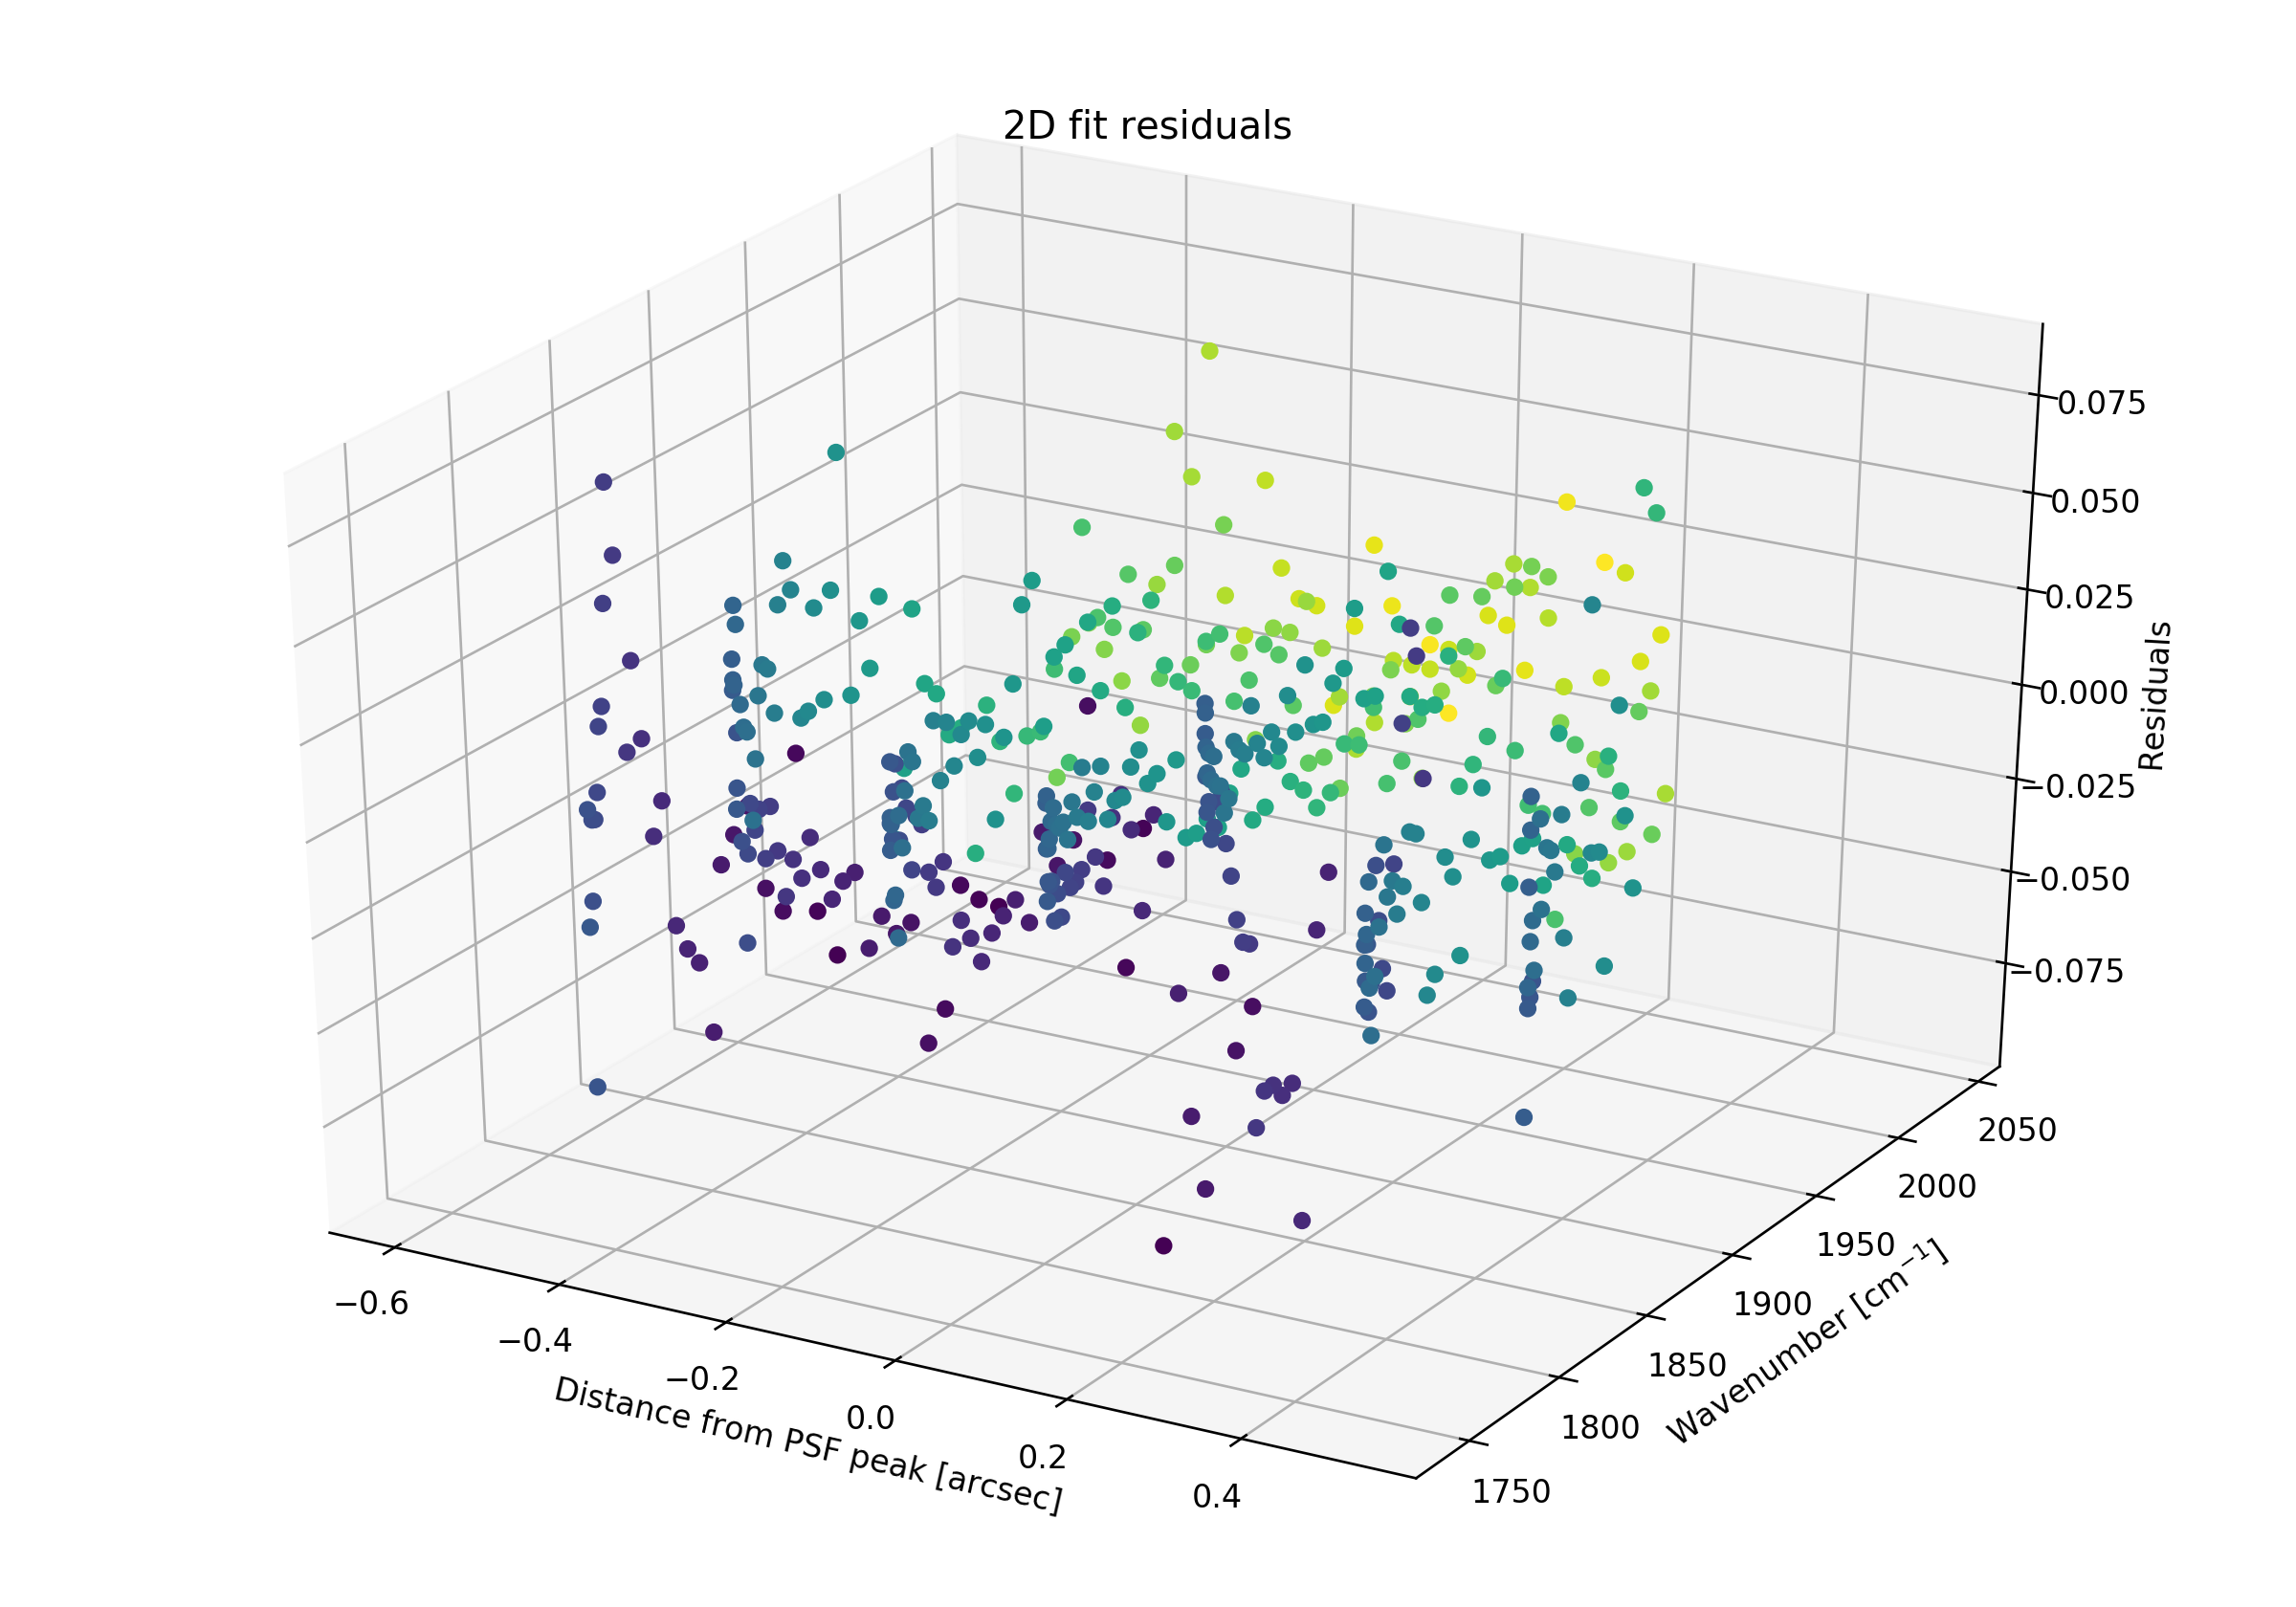

<IPython.core.display.Javascript object>


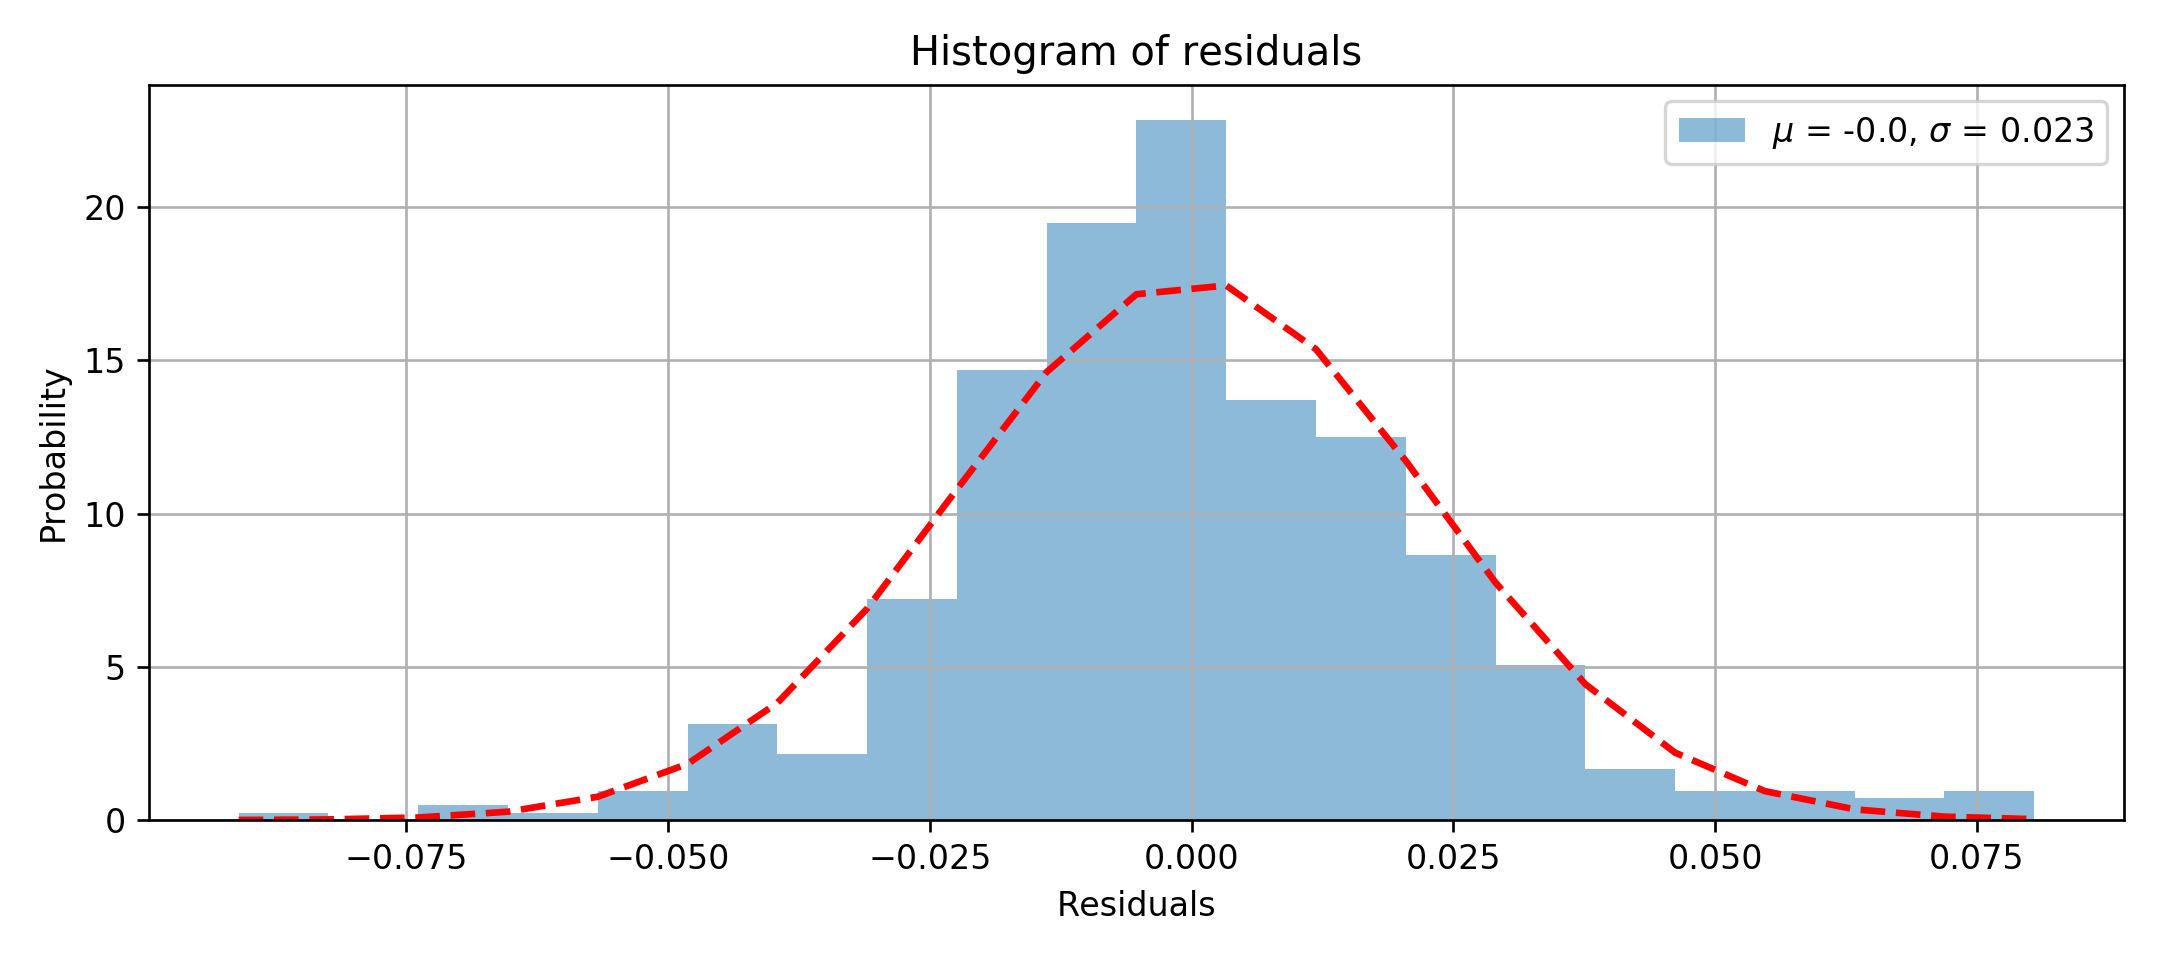

In [14]:
# 2D polyfit weights
m = fringe_depth_polyfit_weights[slice_offset+1,:]

# Evaluate the 2D polynomial fit on a regular grid...
nx, ny = 20, 20
xx, yy = np.meshgrid(np.linspace(centered_alpha_wvnrs[key].min(), centered_alpha_wvnrs[key].max(), nx),
                     np.linspace(ps_wvnr_lists[key].min(), ps_wvnr_lists[key].max(), ny))
zz = polyval2d(xx, yy, m)
pred = polyval2d(centered_alpha_wvnrs[key], ps_wvnr_lists[key], m)

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
ax.scatter(centered_alpha_wvnrs[key],ps_wvnr_lists[key],ps_fringe_depths[key],c=ps_wvnr_lists[key],alpha=1)
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, alpha=0.2)
ax.set_zlim(0.7,1.01)
ax.set_xlabel(r'Distance from PSF peak [arcsec]')
ax.set_ylabel(r'Wavenumber [cm$^{-1}$]')
ax.set_zlabel(r'Fringe depth')
ax.tick_params(axis='both',labelsize=10)
ax.set_title('2D fit')
plt.tight_layout()

sel = ps_fringe_depths[key] > 0.6 

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
ax.scatter(centered_alpha_wvnrs[key][sel],ps_wvnr_lists[key][sel],(ps_fringe_depths[key]-pred)[sel],c=ps_wvnr_lists[key][sel],alpha=1)
ax.set_xlabel(r'Distance from PSF peak [arcsec]')
ax.set_ylabel(r'Wavenumber [cm$^{-1}$]')
ax.set_zlabel(r'Residuals')
ax.tick_params(axis='both',labelsize=10)
ax.set_title('2D fit residuals')
plt.tight_layout()

plt.figure(figsize=(9,4))
(mu, sigma) = norm.fit((ps_fringe_depths[key]-pred)[sel][abs(ps_fringe_depths[key]-pred)[sel]<0.2])
n, bins, patches = plt.hist((ps_fringe_depths[key]-pred)[sel][abs(ps_fringe_depths[key]-pred)[sel]<0.2], 20, density=1, alpha=0.5,label=r'$\mu$ = {}, $\sigma$ = {}'.format(round(mu,3),round(sigma,3)))
y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Residuals')
plt.ylabel('Probability')
plt.title('Histogram of residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()

### Store output

In [15]:
print(fringe_depth_polyfit_weights)

[[-3.26360420e-04  1.16866443e-03  1.73839113e-04  4.44208733e-05
   1.06845842e-05 -1.54181792e-01  5.41049286e-01  8.09378483e-02
   2.03362512e-02  5.01663568e-03  2.48442503e-04 -8.38208100e-04
  -1.65511822e-04 -1.29107961e-03  3.03131469e-03 -1.32833478e-07
   4.32452394e-07  1.07196030e-07  1.36025199e-06 -3.24258321e-06
   2.36381990e-11 -7.43065946e-11 -2.24195349e-11 -3.61330471e-10
   8.66701492e-10]
 [ 3.59754749e-05  3.26405675e-04  1.23550290e-04  2.18977907e-05
   1.37497384e-05  1.26463349e-02  1.53179292e-01  5.77493401e-02
   1.01581246e-02  6.48250532e-03 -1.87375240e-05 -2.34828615e-04
  -3.15815715e-05 -1.03065156e-04 -5.08389558e-04  9.66427969e-09
   1.19908274e-07 -1.66422052e-08  1.01644500e-07  5.42600130e-07
  -1.67255309e-12 -2.03924933e-11  8.97079994e-12 -2.63893876e-11
  -1.45289671e-10]
 [ 2.26769054e-04 -5.63818686e-05  1.62312910e-03 -1.27308417e-04
   1.63536067e-04  3.96910829e-02 -2.56041023e-02  7.57860265e-01
  -6.06608250e-02  7.66532541e-02 -6.2

In [15]:
np.save(outputpath+'fringe_depth_polyfit_weights',fringe_depth_polyfit_weights)